### COVID-19 Data Science Challenge Protect Purdue: Predicting social crowding in Tippecanoe county.

## Background
---

In this project, the aim is to make a prediction of foot traffic for week 44 (Since Indiana recorded first COVID-19 case) in 1804 Point of Interests (POIs) in Tippecanoe County in Indiana, United States of America (a regression task). The data that is being used has been collected from the week 1 to week 43 and has is available as a BIgQuery project file. The schema of the tables that will be used for this project can be found [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vQUgT-CyXoPO6Fa4r4YlwF6uqHMvcqiWM4UNlUqYNdrljntzZsL8sU9-BIZZIOdd_CO3W5ILB_MW4TW/pubhtml).

To start with, the six tables would be imported from the BigQuery project and stored as a pandas DataFrame. Then, Exploratory Data Analysis (EDA) would be carried out on the data to better understand their relationships for feature selection for the modeling task. For this challenge, some of the various models I used were:
* Arima
* Random Forest
* LightGBM
* Catboost

The result presented in this report was obtained using catboost. This report visualized the effectiveness of the policies taken during the fall in five poi locations that reported the highest cases of the virus.

In [106]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from ipywidgets import *
from ipyleaflet import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import os
from ipywidgets.embed import embed_minimal_html
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
 !jupyter labextension install jupyter-leaflet

In [105]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='keys.json'   #using unique key to get access to the data 
bigquery_client = bigquery.Client(project='ironhacks-covid19-data')
bigquery_client
bigquery_client = bigquery.Client()

def table_pandas(table):  #function to convert the six tables to pandas DataFrame
    QUERY = """

    SELECT *
    FROM ironhacks-covid19-data.ironhacks_covid19_competition.{i}

    """.format(i=table)

    query_job = bigquery_client.query(QUERY)
    return query_job.to_dataframe()

In [107]:
main_data = table_pandas('weekly_patterns')

In [108]:
main_data['date_start'] =  pd.to_datetime(main_data['date_start'], format='%Y-%m-%d') #convert to datetime

In [109]:
xx = pd.read_csv('submission_prediction_output8.csv')

In [110]:
dt = datetime.datetime(2020, 11, 2)   ##week 44

In [111]:
xx['date_start'] = dt

In [25]:
xx.head()

,poi_id,raw_visit_counts,date_start
638,322265e6-5192-435d-b982-e25f5c1310f6,3096,2020-11-02
544,69288fb3-9c48-44ee-a0f4-e7ac8270ec74,2391,2020-11-02
635,55ef29c0-bef9-4848-97da-78d5d85a9a7a,2207,2020-11-02
543,6face3b1-ebca-4609-8a93-2235f3c3642f,1884,2020-11-02
535,41093334-0805-4f4f-bc11-ee24a42fc637,1829,2020-11-02


In [15]:
xx.sort_values('raw_visit_counts', inplace=True, ascending=False)

In [20]:
top_5 = list(xx.head()['poi_id']); top_5  ## Top 5 most infected locations

['322265e6-5192-435d-b982-e25f5c1310f6',
 '69288fb3-9c48-44ee-a0f4-e7ac8270ec74',
 '55ef29c0-bef9-4848-97da-78d5d85a9a7a',
 '6face3b1-ebca-4609-8a93-2235f3c3642f',
 '41093334-0805-4f4f-bc11-ee24a42fc637']

### Merging the main_data with the predictions

In [112]:
def new_data(i):
    poi_data = main_data[main_data['poi_id']==i][['raw_visit_counts', 'date_start']]
    new_poi_data = xx[xx['poi_id']==i][['raw_visit_counts', 'date_start']]
    return pd.concat([poi_data, new_poi_data], ignore_index=True).set_index('date_start')

In [114]:
def plot_gra(df, i):
    fig, ax = plt.subplots(figsize=(20,9))
    ax.plot(df, marker='o', linestyle='-')
    ax.set_ylabel('Weekly COVID-19 Cases')
    ax.set_title('Time Series Chart for {}'.format(list(main_data[main_data['poi_id']==top_5[i]]['location_name'])[0]))

#### For the first most infected location in week 44

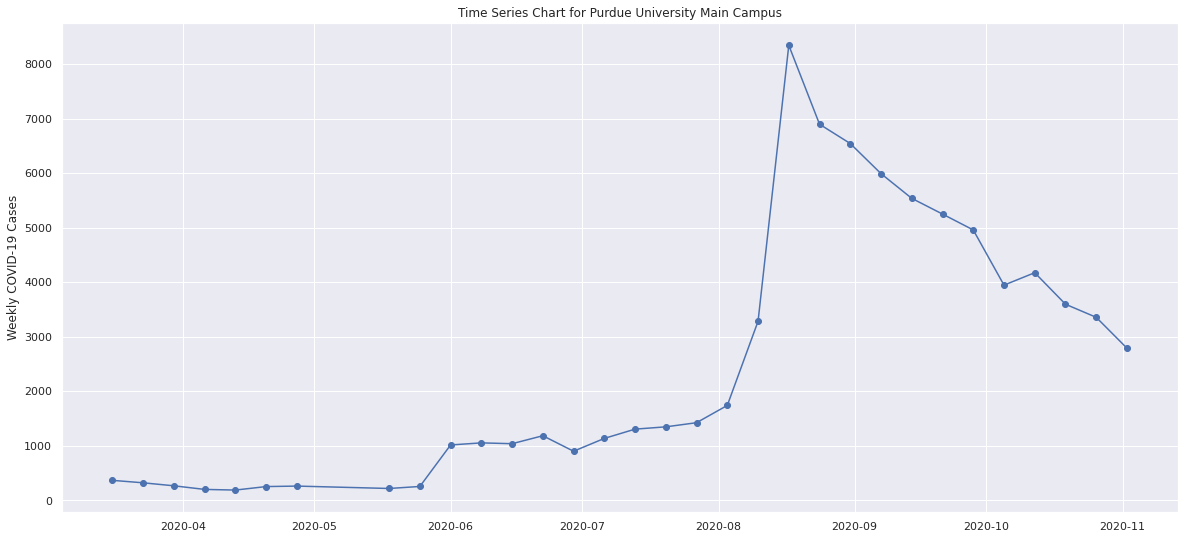

In [115]:
plot_gra(new_data(top_5[0]), 0)

The Fall Semester at Purdue started around August and it is obvious from the time-series plot that the first period of the resumption saw some increase in cases on campus. However, it steadily reduced and this can be attributed to the students and staff commitment to the Protect Purdue Pledge. Therefore, going forward to the spring semester, continuing the protect purdue pledge would greatly help.

#### For the second most infected location in week 44

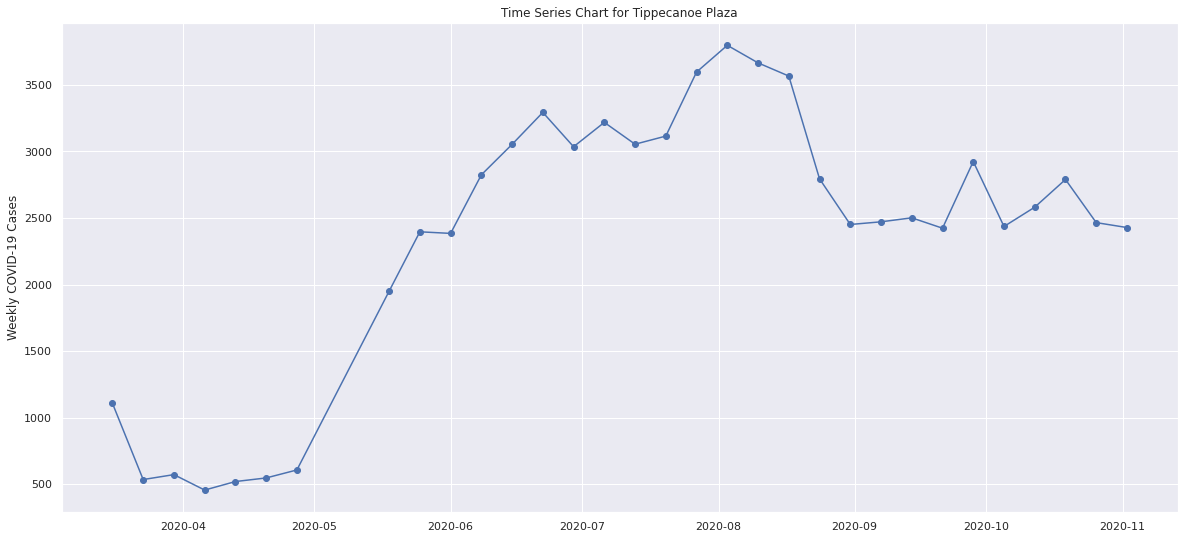

In [116]:
plot_gra(new_data(top_5[1]), 1)

The cases recorded here has been steady for weeks which implies that people living around here should be advised to self isolate as there is a high chance they might have been infected.  

#### For the third most infected location in week 44

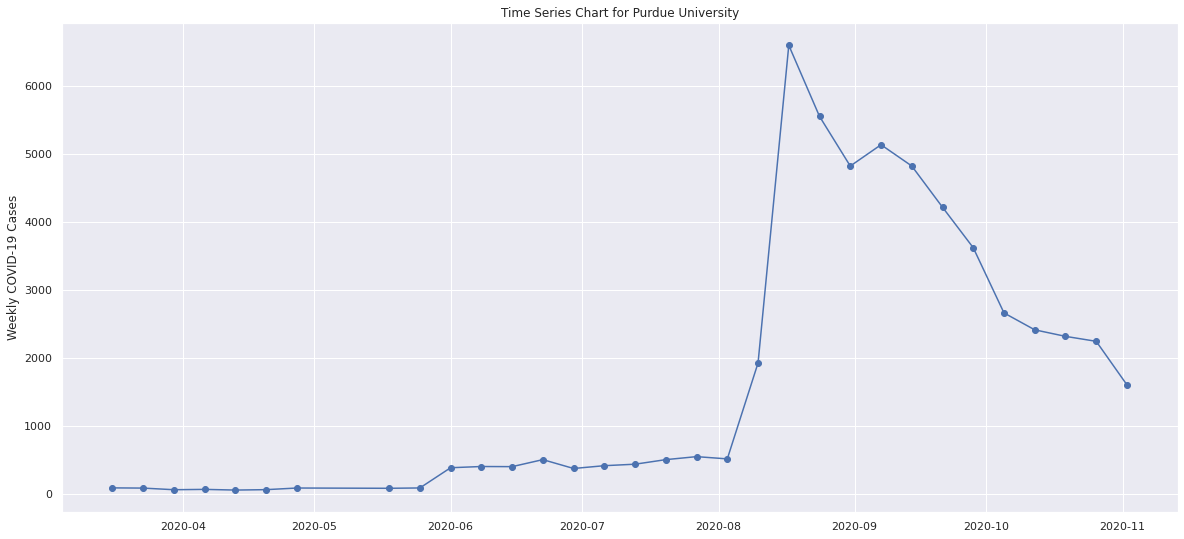

In [117]:
plot_gra(new_data(top_5[2]), 2)

Just as it was for the main campus, the overall cases has been staedily reducing for the whole of the university most likely because of the pledge.

#### For the fourth most infected location in week 44

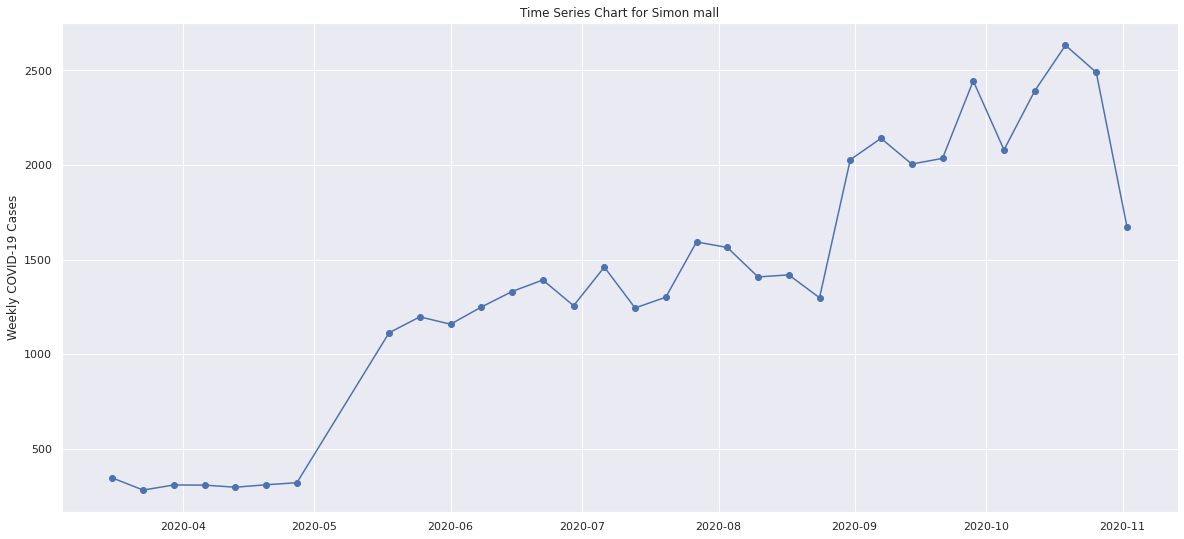

In [118]:
plot_gra(new_data(top_5[3]), 3)

As this is a mall, it is an essential service provider and it is less likely people will not visit. Therefore, proper masking and social distancing procedure should be propagated to further steep the curve.

#### For the fifth most infected location in week 44

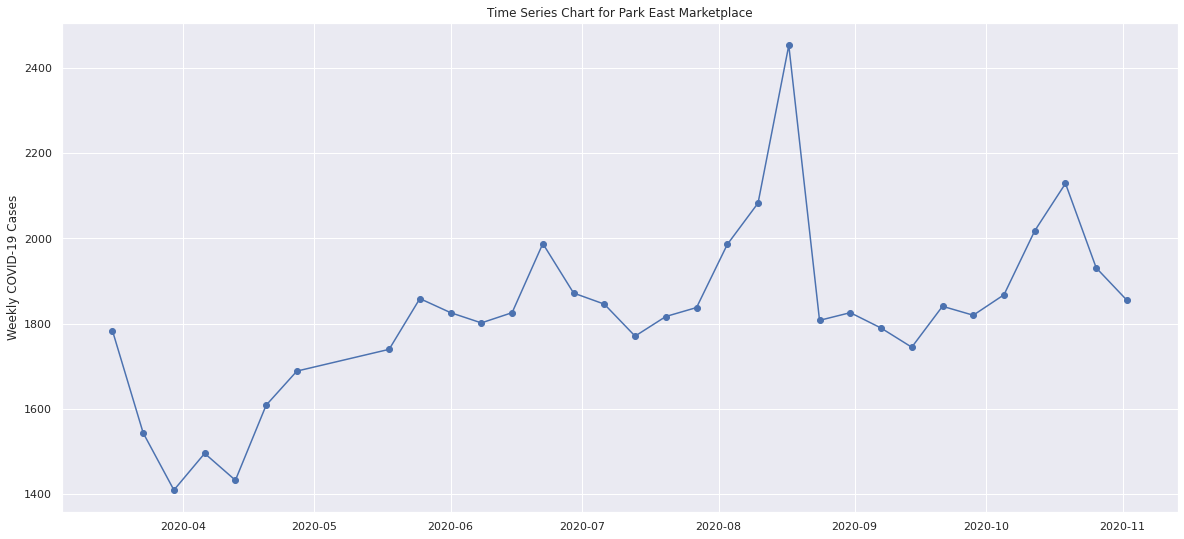

In [126]:
plot_gra(new_data(top_5[4]), 4)

In [120]:
w = main_data[(main_data['week_number']== 43) | (main_data['week_number']== 11) | (main_data['week_number']== 30) 
              | (main_data['week_number']== 39) | (main_data['week_number']== 25)][['poi_id', 'location_name', 'longitude', 'latitude']]

In [121]:
w.drop_duplicates(subset=['poi_id'], inplace=True)
w.reset_index(inplace = True)
w.drop(columns = 'index', inplace=True)

In [122]:
df_merge_col = pd.merge(w, xx, on='poi_id')

### Temporal Mapping

The predictions for week 44 is visualized below on an interactive map showing places around Tipcanoe county and the predicted values

In [123]:
# CONSTANTS
MAP_LAT=40.3900
MAP_LON=-86.8220
MAP_CENTER = (MAP_LAT, MAP_LON)

In [124]:
m = Map(center=MAP_CENTER, zoom=10)

markers = []

for index, point in df_merge_col.iterrows():
    marker = Marker(
        location=[point.latitude, point.longitude],
        draggable=False,
    )
    marker_message = HTML()
    marker_message.value = "<strong>" + str(point.location_name) + "</strong>" + "<br>Visit Count: " + str(point.raw_visit_counts)
    marker.popup = marker_message
    markers.append(marker)

m.add_layer(MarkerCluster(markers=markers))

display(m)

Map(center=[40.39, -86.822], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [125]:
embed_minimal_html('submission_report_visualization.html', views=[m])

### Recomendations

To say I am excited I completed this hackathon would be largely an understatement. In fact, I did not submit the first three submissions because I could not set up the model using my favorite xgboost. However, the constant reminder via email and the support of being placed in a group reinvigorated my spirit and I am really glab I explored four different models for the hackathon. I think I can now change my LinkedIn header from "data analyst" to "data scientist" after mont 